In [49]:
from dotenv import load_dotenv
import os 
from langchain_openai import AzureChatOpenAI

load_dotenv()

True

In [50]:
os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')

In [51]:
llm = AzureChatOpenAI(
    api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
)

llm.invoke("hi").content

'Hello! How can I assist you today?'

In [52]:
from typing_extensions import TypedDict, cast
from langchain_core.prompts import ChatPromptTemplate

In [53]:
class State(TypedDict):
    application: str
    experience_level: str
    skill_match: str
    response: str

In [54]:
from pydantic import BaseModel
from typing import Literal

class SkillMatch(BaseModel):
    skill_result: Literal['Match', 'No Match']

In [55]:
def categorize_experience(state: State) -> State:
    print("\nCategorizing the experience level of candidate : ")
    prompt = ChatPromptTemplate.from_template(
        "Based on the following job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'"
        "Application: {application}"
    )
    
    chain = prompt | llm 
    experience_level = chain.invoke({"application": state['application']}).content
    print(F"Experience Level: {experience_level}")
    return {"experience_level": experience_level}

def assess_skillset(state: State) -> State:
    print("\nAssessing the skillset of candidate : ")
    # prompt = ChatPromptTemplate.from_template(
    #     "Based on the job application for a Python Developer, assess the candidate's skillset"
    #     "Respond with either 'Match' or 'No Match'"
    #     "Application: {application}"
    # )
    # chain = prompt | llm
    # skill_match = chain.invoke({"application": state['application']}).content 
    # print(f"Skill Match: {skill_match}")
    # return {"skill_match": skill_match}
    
    system_prompt ="""Based on the job application for a Python Developer, assess the candidate's skillset
        "Respond with either 'Match' or 'No Match'"""
    structured_llm = llm.with_structured_output(SkillMatch, method="function_calling")
    
    result = cast(
        SkillMatch,
        structured_llm.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": state['application']}
        ]
    )
    )
    return {"skill_match": result.skill_result}

def schedule_hr_interview(state: State) -> State:
    print("\nSchedule the interview: ")
    return {"response": "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
    print("Escalating to recruiter")
    return {"response": "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
    print("Sending rejecting email")
    return {"response": "Candidate doesn't meet JD and has been rejected."}

In [56]:
from langgraph.graph import StateGraph, START, END

In [57]:
def route_app(state:State) -> str:
    if (state['skill_match'] == "Match"):
        return "schedule_hr_interview"
    elif (state['experience_level'] == "Senior-level"):
        return "escalate_to_recruiter"
    else:
        return "reject_application"

In [58]:
workflow = StateGraph(State)

workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

workflow.add_edge(START, "categorize_experience")
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_app)

workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)

app = workflow.compile()

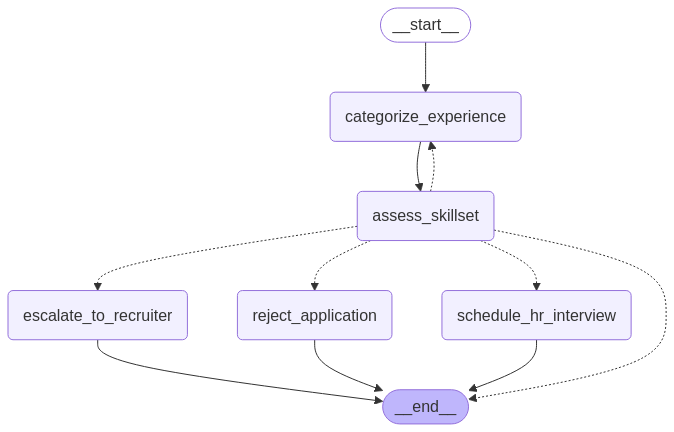

In [59]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [60]:
def run_candidate_screening(application: str):
    results = app.invoke({"application": application})
    return {
        "experience_level": results['experience_level'],
        "skill_match": results['skill_match'],
        "response": results["response"]
    }

In [61]:
application_text = "I have 10 years of experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level: Based on the provided job application, the candidate should be categorized as 'Senior-level'. The candidate has 10 years of experience in software engineering, which typically qualifies them for a senior-level position.

Assessing the skillset of candidate : 

Schedule the interview: 


Computed Results :
Application: I have 10 years of experience in software engineering with expertise in Python
Experience Level: Based on the provided job application, the candidate should be categorized as 'Senior-level'. The candidate has 10 years of experience in software engineering, which typically qualifies them for a senior-level position.
Skill Match: Match
Response: Candidate has been shortlisted for an HR interview.
